# 离群点分析与异常检测

本次作业从Anomaly Detection Meta-Analysis Benchmarks提供的benchmark数据集中任选两个进行离群点分析和异常检测。

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [2]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler

C:\Users\yjn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# reading the big mart sales training data
path = 'skin_benchmark_0001.csv'
df = pd.read_csv(path, header=0, index_col=None, engine='python', encoding='utf-8')

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['R', 'G']] = scaler.fit_transform(df[['R', 'G']])
df[['R', 'G']].head()

X1 = df['R'].values.reshape(-1, 1)
X2 = df['G'].values.reshape(-1, 1)
X = np.concatenate((X1, X2), axis=1)

random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

C:\Users\yjn\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\yjn\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\yjn\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\yjn\anaconda3\lib\site-packages\pyod\models\base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
C:\Users\yjn\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\yjn\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


OUTLIERS :  0 INLIERS :  6000 Angle-based Outlier Detector (ABOD)


C:\Users\yjn\anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\yjn\anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


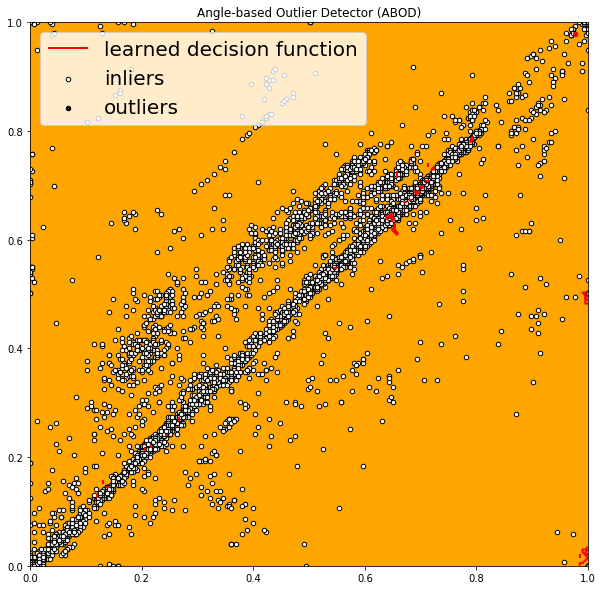

OUTLIERS :  300 INLIERS :  5700 Cluster-based Local Outlier Factor (CBLOF)


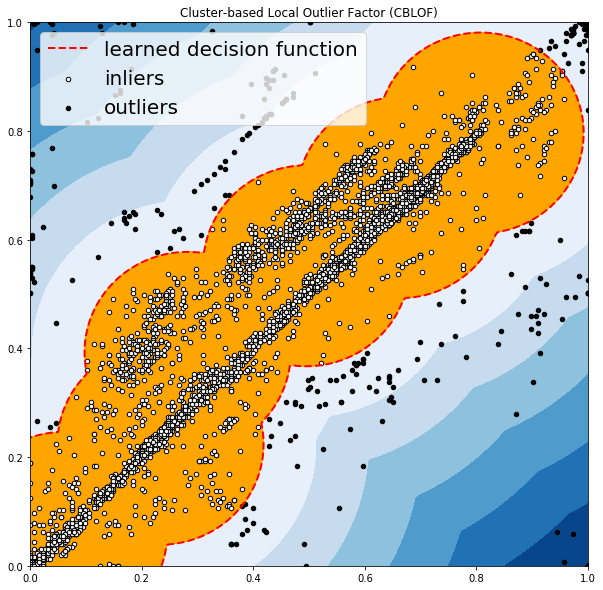

OUTLIERS :  241 INLIERS :  5759 Feature Bagging


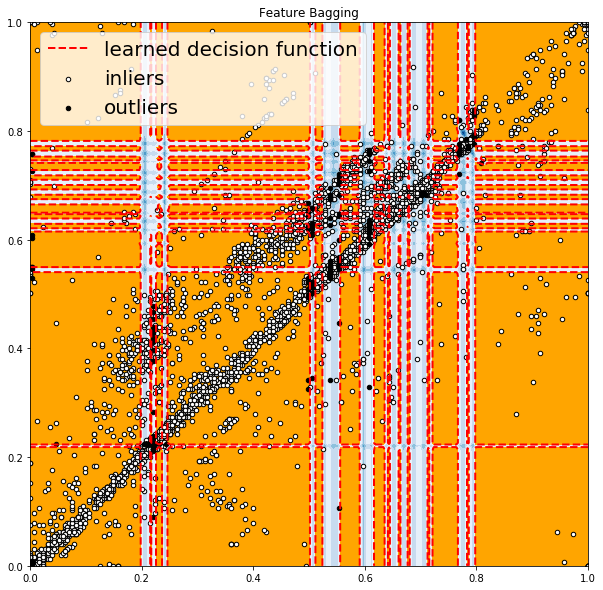

OUTLIERS :  218 INLIERS :  5782 Histogram-base Outlier Detection (HBOS)


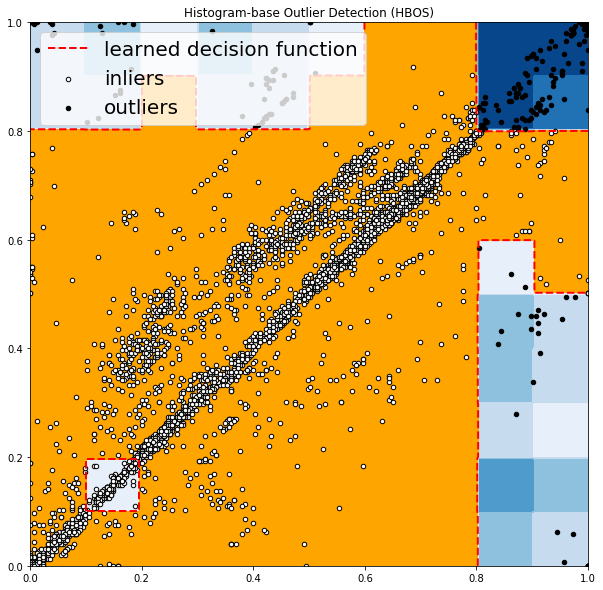

OUTLIERS :  297 INLIERS :  5703 Isolation Forest


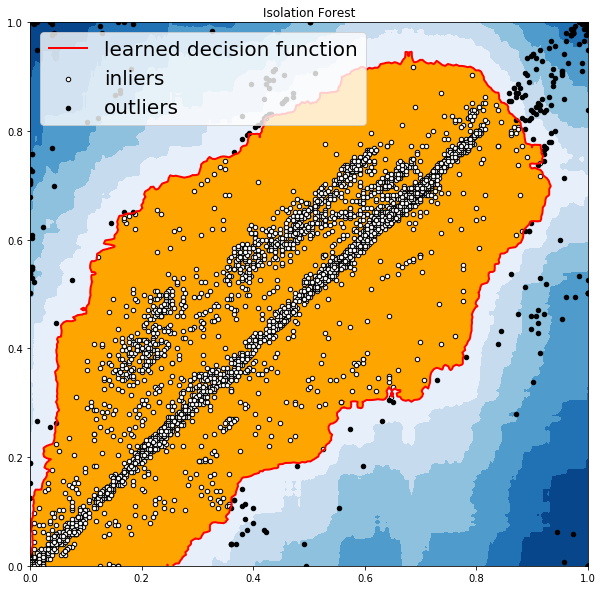

OUTLIERS :  243 INLIERS :  5757 K Nearest Neighbors (KNN)


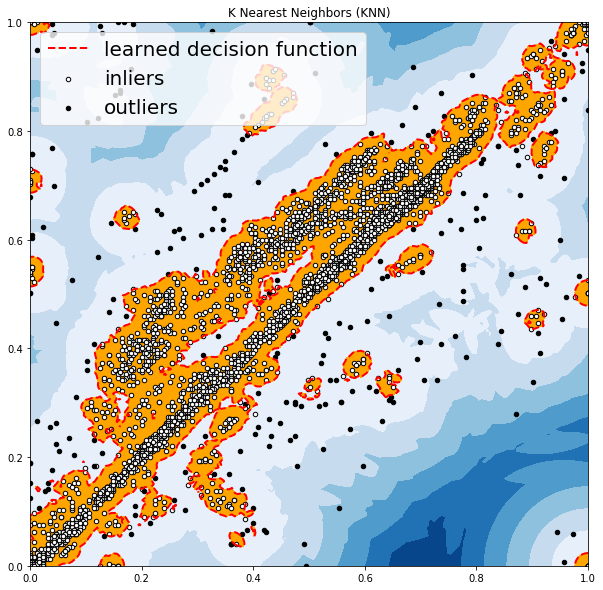

OUTLIERS :  172 INLIERS :  5828 Average KNN


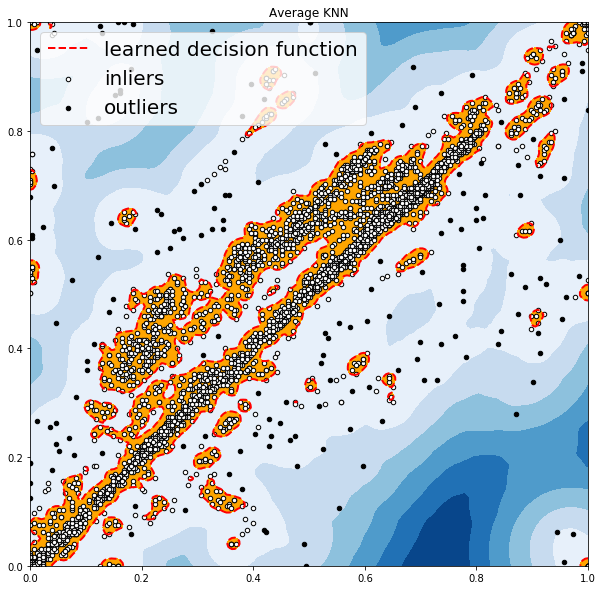

Over


In [7]:
xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score，预测原始异常值
    scores_pred = clf.decision_function(X) * -1

    # prediction of a datapoint category outlier or inlier，数据点类别的预测，离群值或非离群值
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))

    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()

    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 = np.array(dfx['R'][dfx['outlier'] == 0]).reshape(-1, 1)
    IX2 = np.array(dfx['G'][dfx['outlier'] == 0]).reshape(-1, 1)

    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 = dfx['R'][dfx['outlier'] == 1].values.reshape(-1, 1)
    OX2 = dfx['G'][dfx['outlier'] == 1].values.reshape(-1, 1)

    print('OUTLIERS : ', n_outliers, 'INLIERS : ', n_inliers, clf_name)

    # threshold value to consider a datapoint inlier or outlier
    threshold = scipy.stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
    # 决策函数计算每个点的原始异常值
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    # fill blue map colormap from minimum anomaly score to threshold value
    # 填充从最小异常值到阈值的蓝色图颜色图
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to thresold
    # 在异常分数等于阈值处绘制红色等高线
    a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    # 填充橙色的等值线，其中异常值范围为阈值到最大异常值
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    b = plt.scatter(IX1, IX2, c='white', s=20, edgecolor='k')
    c = plt.scatter(OX1, OX2, c='black', s=20, edgecolor='k')
    plt.axis('tight')

    # loc=2 is used for the top left corner
    plt.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'inliers', 'outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

print('Over')